# **Natural Language Processing - Mini-Challenge 2: Sentiment Analysis**

For information about this mini-challenge, please view the document `NPR-Mini-Challenge-2-Sentiment-Analysis.pdf` in the `docs` directory.

## **1. Setup and Data Selection**

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import transformers
from tqdm.notebook import tqdm  # Use tqdm.notebook for Jupyter Notebook compatibility
from transformers import BertTokenizer
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join('../', 'src')))

from utils import *
from weak_labelling import *

transformers.logging.set_verbosity_error()

device = get_device()

Using MPS (Metal Performance Shaders)
Selected device: mps


### **Dataset Overview**
We utilize the [Stanford Sentiment Treebank (SST-2)](https://huggingface.co/datasets/stanfordnlp/sst2), a benchmark dataset for sentiment classification tasks. SST-2 consists of 11'855 single sentences extracted from movie reviews, parsed with the Stanford parser. These sentences are binary-labeled as either positive or negative, excluding neutral phrases. The dataset provides a comprehensive resource for evaluating sentiment classification models in natural language processing.

### **Practical Considerations**

In real-world scenarios, it is common to have a small amount of labeled data and a large pool of unlabeled data. To emulate this condition while effectively leveraging weak labeling techniques, we adopt the following approach:

- **Training Data**: A sample of 5'000 labeled data points is used for initial training. This limited dataset mimics a scenario where labeled data is scarce.

- **Weak Labeling Pool**: The remaining labeled data points (around 52'114 samples) are reserved to simulate an unlabeled pool for weak labeling. After applying weak labeling techniques, the top 5'000 high-confidence weak labels (for example, based on cosine similarity or other metrics) will be selected and added to the training data. This allows us to test if incorporating high-quality weak labels improves model performance.

- **Evaluation Data**: A separate dataset of 10'000 samples (df_eval_pool) is reserved for evaluation. The evaluation will be performed twice:

    - Without adding the weak-labeled data to the training set.
    
    - After adding the high-confidence weak-labeled data to the training set.

This setup ensures a clear separation of datasets for training and evaluation, allowing us to analyze the impact of weak labeling on model performance. By mimicking real-world constraints, this approach balances the need for practical experimentation with efficient use of available data.

In [2]:
# Load the training dataset
df_train = pd.read_csv("../data/train.csv")

# Reserve 10'000 samples for evaluation (to be kept separate from other splits)
df_train_remaining, df_eval_pool = train_test_split(
    df_train, test_size=10000, random_state=42, shuffle=True
)

# From the remaining data, sample 5'000 for training
df_train_sampled, df_weak_labeling_pool = train_test_split(
    df_train_remaining, test_size=(len(df_train_remaining) - 5000), random_state=42, shuffle=True
)

print(f"Dataset Sizes:")
print(f"Training (labeled): {len(df_train_sampled)} samples")
print(f"Weak Labeling Pool: {len(df_weak_labeling_pool)} samples")
print(f"Evaluation Pool: {len(df_eval_pool)} samples")

Dataset Sizes:
Training (labeled): 5000 samples
Weak Labeling Pool: 52349 samples
Evaluation Pool: 10000 samples


### **Hierarchical Nested Splits**
To analyze model performance variability and the effect of training data size, we create **hierarchical nested splits** from the sampled training data:

- **Split Sizes:** 10 training splits are created, each varying in size from 1% to 100% of the 5'000 sampled data (`[0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0]`).

- **Shuffling and Variability:** To reduce bias and assess performance variability, the entire training data is shuffled and 10 independent sets of nested splits are created. This enables robust analysis across different training configurations.


In [3]:
split_sizes = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0]
nested_splits_sets = create_nested_splits(df_train_sampled, split_sizes, num_sets=10)

Created Set 1 with nested splits.
Created Set 2 with nested splits.
Created Set 3 with nested splits.
Created Set 4 with nested splits.
Created Set 5 with nested splits.
Created Set 6 with nested splits.
Created Set 7 with nested splits.
Created Set 8 with nested splits.
Created Set 9 with nested splits.
Created Set 10 with nested splits.


For better organization and reproducibility, the hierarchical splits are saved in a structured folder format:

- **Base Folder**: ../data/nested_splits/

- **Subfolders**: Each set of splits is stored in its own subfolder (for example `set_1`, `set_2`, etc.).

- **Split Files**: Each split (for example 1%, 10%, etc.) within a set is saved as a CSV file (for example `split_1.csv`).

Now that we have loaded our data we can start creating our baseline model.

---

## **2. Baseline Model**

In this task, we utilize Fine-Tuning, where all layers of a pre-trained model (`bert-base-uncased`) are retrained to adapt to the sentiment classification task. This approach is suitable given the availability of hierarchical data splits ranging from 1% to 100% and the need to incorporate weak labels effectively. Fine-tuning enables us to fully leverage the model's pre-trained knowledge while tailoring it to our specific dataset.

### **Methodology**

1. **Model**: We use BertForSequenceClassification for fine-tuning. The model's pre-trained transformer layers and the classification head are optimized for binary sentiment analysis.

2. **Data Splits**: 
    - Hierarchical nested splits ranging from 1% to 100% of the training data are created. 
    
    - Multiple sets of these splits are generated to test the variability in model performance across randomized subsets.

3. **Training**:
    - Tokenized input sentences are passed to the model.
    
    - Each split is trained individually to evaluate performance at different data sizes.

4. **Metrics**:
    - Metrics such as accuracy, precision, recall and F1-score are recorded for each split.
    
    - ariability in performance across different split sets is analyzed.

5. **Comparison**: Performance is compared across data splits, with and without weak labels, to gain meaningful insights into the impact of labeled data size and weak labeling.

In [4]:
# Initialize Tokenizer and tokenize validation set
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create validation dataset from reserved pool
validation_ds = tokenize_dataset(df_eval_pool, tokenizer)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [5]:
# if variability_metrics.csv exists, load it and dont train model
if os.path.exists("../data/variability_metrics.csv"):
    df_metrics = pd.read_csv("../data/variability_metrics.csv")
    tqdm.write("Metrics loaded from file.")
else:
    tqdm.write("Metrics file not found. Training model...")

    metrics = []

    outer_pbar = tqdm(nested_splits_sets.items(), desc="Processing Sets", leave=True)
    for set_name, splits in outer_pbar:
        inner_pbar = tqdm(splits.items(), desc=f"Training Splits in {set_name}", leave=False)
        for size, train_df in inner_pbar:
            tqdm.write(f"Training with {size}% of data from {set_name}...")

            # Tokenize training data
            train_ds = tokenize_dataset(train_df, tokenizer)

            # Define a unique output directory for each split
            output_dir = f"./model_output/{set_name}_{size}"

            # Train the model and collect metrics
            split_metrics = train_and_evaluate(
                train_dataset=train_ds,
                eval_dataset=validation_ds,
                output_dir=output_dir,
                epochs=1,
                batch_size=8,
                learning_rate=2e-5,
                weight_decay=0.01
            )

            # Add split details to metrics
            split_metrics["split_size"] = size
            split_metrics["set_name"] = set_name
            metrics.append(split_metrics)

            tqdm.write(f"Completed training for {set_name} with {size}% data.")

        # After finishing a set, you can write a message if needed.
        tqdm.write(f"Finished processing splits in {set_name}.")

    df_metrics = pd.DataFrame(metrics)
    df_metrics.to_csv("../data/variability_metrics.csv", index=False)

    tqdm.write("All training runs completed and metrics saved.")

Metrics loaded from file.


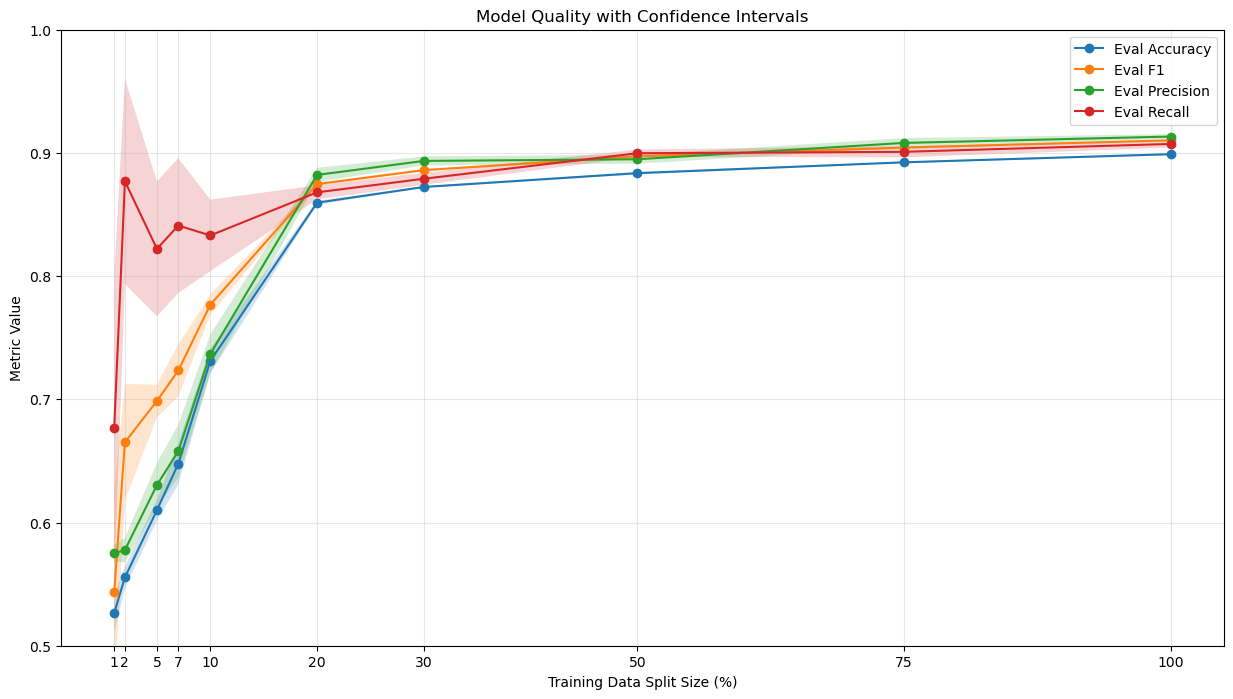

In [6]:
plot_metrics_with_confidence(
    df_metrics, 
    x_col="split_size", 
    y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"],
    title="Model Quality with Confidence Intervals"
)

#### **Observations from the Plot**

- When using small fractions of training data (1% - 10%), there is significant variability and lower metric values, especially in metrics like Accuracy and Precision. This variability is represented by the wide confidence intervals, indicating model instability.

- As more training data is used, metrics improve steadily. Confidence intervals start to shrink, suggesting greater stability in model performance.

- Beyond approximately 30% - 50% of training data, all metrics converge towards their maximum values and confidence intervals become almost negligible. This indicates the model benefits from larger datasets but saturates after a certain point.

- Recall appears to have higher variability in smaller training splits but stabilizes quickly with more data.

The graph effectively demonstrates the importance of data quantity for model performance and highlights diminishing returns as the data volume approaches the total available dataset.

### **Hyperparameter Tuning**

- **Learning Rate**: The learning rate is a critical hyperparameter that controls the step size during optimization. We experiment with different learning rates to find the optimal value that balances training speed and convergence.

- **Weight Decay**: Weight decay is a regularization term that penalizes large weights in the model. We tune this hyperparameter to prevent overfitting and improve generalization.

In [7]:
# if hyperparameter_tuning_results.csv exists, load it and dont train model
if os.path.exists("../data/hyperparameter_tuning_results.csv"):
    df_hyperparameters = pd.read_csv("../data/hyperparameter_tuning_results.csv")
    tqdm.write("Metrics loaded from file.")
else:
    tqdm.write("Metrics file not found. Training model...")

    # use random 100% split to train the model with different hyperparameters
    df_set_1_train = pd.read_csv("../data/nested_splits/set_1/split_100.csv")

    # Tokenize datasets
    train_ds = tokenize_dataset(df_set_1_train, tokenizer)
    eval_ds = tokenize_dataset(df_eval_pool, tokenizer)

    # Define hyperparameter values to test
    learning_rates = [4e-5, 5e-5]
    weight_decays = [0.0, 0.01, 0.05, 0.1]

    # Dictionary to store results
    results = []

    # Perform hyperparameter tuning
    for lr in learning_rates:
        for wd in weight_decays:
            output_dir = f"./model_output/lr_{lr}_wd_{wd}"
            print(f"Training with learning_rate={lr}, weight_decay={wd}")
            
            # Train and evaluate the model
            metrics = train_and_evaluate(
                train_dataset=train_ds,
                eval_dataset=eval_ds,
                output_dir=output_dir,
                epochs=1,
                batch_size=8,
                learning_rate=lr,
                weight_decay=wd
            )
            
            # Add hyperparameter details to metrics
            metrics['learning_rate'] = lr
            metrics['weight_decay'] = wd
            results.append(metrics)

    # Save the results to a CSV file for analysis
    df_hyperparameters = pd.DataFrame(results)
    df_hyperparameters.to_csv("../data/hyperparameter_tuning_results.csv", index=False)

    print("Hyperparameter tuning completed. Results saved to ../data/hyperparameter_tuning_results.csv.")

Metrics loaded from file.


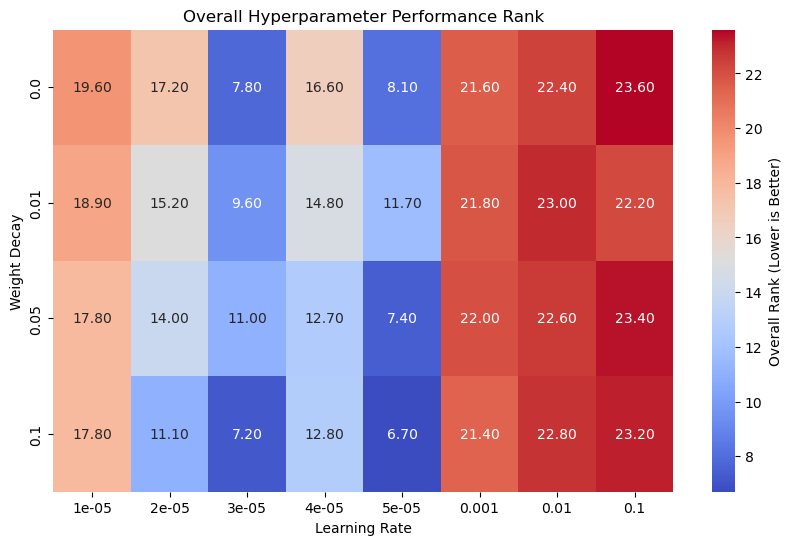

In [8]:
# Normalize and rank each metric
ranked_df = df_hyperparameters.copy()

# Reverse rankings for metrics where lower is better (e.g., eval_loss)
ranked_df["eval_loss_rank"] = ranked_df["eval_loss"].rank(ascending=True)
ranked_df["eval_accuracy_rank"] = ranked_df["eval_accuracy"].rank(ascending=False)
ranked_df["eval_precision_rank"] = ranked_df["eval_precision"].rank(ascending=False)
ranked_df["eval_recall_rank"] = ranked_df["eval_recall"].rank(ascending=False)
ranked_df["eval_f1_rank"] = ranked_df["eval_f1"].rank(ascending=False)

# Compute overall rank (average rank across all metrics)
ranked_df["overall_rank"] = ranked_df[
    ["eval_loss_rank", "eval_accuracy_rank", "eval_precision_rank", "eval_recall_rank", "eval_f1_rank"]
].mean(axis=1)

# Visualize the overall ranks in a heatmap
pivot_table = ranked_df.pivot(index="weight_decay", columns="learning_rate", values="overall_rank")
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={"label": "Overall Rank (Lower is Better)"}
)
plt.title("Overall Hyperparameter Performance Rank")
plt.xlabel("Learning Rate")
plt.ylabel("Weight Decay")
plt.show()


---

## **2. Text Embeddings**

To represent texts numerically, we use **sentence embeddings** generated by the `all-MiniLM-L6-v2` model from the Sentence-Transformers library. These embeddings capture the semantic meaning of entire sentences as high-dimensional vectors, enabling us to quantify similarities between texts. By focusing on the validation and test sets, we ensure an unbiased evaluation of how well embeddings generalize to unseen data.

In [9]:
# Define labeled datasets from train and validation sets
labeled_sentences = df_train_sampled["sentence"].tolist()     # Train set sentences
labeled_labels = df_train_sampled["label"].tolist()           # Train set labels

# Generate embeddings with specifies model
model_name = "all-MiniLM-L6-v2"
embeddings = generate_embeddings(labeled_sentences, model_name, device)

# Dimension of embeddings
print(embeddings.shape)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

(5000, 384)


### **Are the embeddings standardized?**

If the mean is close to 0 and the standard deviation is close to 1, then the embeddings are standardized. Otherwise, they are not.

In [10]:
import numpy as np

# Check mean and standard deviation for each dimension
mean_embeddings = np.mean(embeddings, axis=0)
std_embeddings = np.std(embeddings, axis=0)

print(f"Mean of embeddings across dimensions: {mean_embeddings.mean():.4f}")
print(f"Standard deviation of embeddings across dimensions: {std_embeddings.mean():.4f}")

Mean of embeddings across dimensions: 0.0003
Standard deviation of embeddings across dimensions: 0.0463


Based on these values, our embeddings are not standardized. We will keep this in mind when using the embeddings for downstream tasks.

### **Samples of most similar sentences**

To assess embedding quality, we calculate **cosine similarity**, which measures the semantic closeness between vectors. For example, we use a reference sentence and calculate its similarity with other sentences in the dataset. The top-5 most similar sentences are retrieved, showcasing the model's ability to group semantically related content.

This section helps us understand how well the embeddings capture sentence meaning and semantic relationships.

In [11]:
reference_index = 4
top_k_embeddings = get_and_print_most_similar_sentences(embeddings, labeled_sentences, reference_index)

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: aims to be funny , uplifting and moving , sometimes all at once . 
Similarity: 0.6745, Sentence: uplifting , funny and wise . 
Similarity: 0.5296, Sentence: 's about individual moments of mood , and an aimlessness that 's actually sort of amazing . 
Similarity: 0.5120, Sentence: to be passionate and truthful 
Similarity: 0.5019, Sentence: to liven things up 


In [12]:
reference_index = 800
top_k_embeddings = get_and_print_most_similar_sentences(embeddings, labeled_sentences, reference_index)

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: without any redeeming value whatsoever 
Similarity: 0.4189, Sentence: offers nothing 
Similarity: 0.4004, Sentence: worth 
Similarity: 0.3956, Sentence: with regret and , ultimately , finding redemption 
Similarity: 0.3584, Sentence: you value your time and money 


In [13]:
reference_index = 410
top_k_embeddings = get_and_print_most_similar_sentences(embeddings, labeled_sentences, reference_index)

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: shrewd but pointless . 
Similarity: 0.5132, Sentence: a shrewd and effective film 
Similarity: 0.4497, Sentence: useless 
Similarity: 0.4238, Sentence: of pointless mayhem 
Similarity: 0.4165, Sentence: toothless 


In conclusion we can see that the most similar sentences to a reference sentence based on cosine similarity are indeed semantically related. This demonstrates the effectiveness of the sentence embeddings in capturing the underlying meaning of the text.

### **Furthest and Closest Sentences**

In [14]:
get_min_max_distance(embeddings, labeled_sentences)

Sentence with the furthest distance to any other sentence:
'a detailed historical document , '

Sentence closest to the most others (minimum average distance):
'it , offering fine acting moments and pungent insights '


### **Quantitative Exploration of Sentence Similarities**

To understand the quality of embeddings generated by our model, we perform a quantitative analysis by exploring the distribution of cosine similarities and pointwise distances within the same class (for example "Label 1" to "Label 1" and "Label 0" to "Label 0"). This helps assess how well the embeddings represent semantic similarities within each class.

#### **Analysis Steps**

1. **Cosine Similarities**:

   - Pairwise cosine similarities are computed for sentence embeddings within the same label group.

   - This quantifies the semantic similarity between embeddings, with values ranging from -1 (completely opposite) to 1 (identical).

2. **Pointwise Distances**:

   - Calculated as (1 - cosine similarity), the pointwise distance provides a dissimilarity measure between embeddings.

   - Lower distances indicate closer embeddings, reflecting better semantic cohesion.

3. **Density Plot**:

   - The KDE-plot visualizes the distribution of cosine similarities for each label, providing insights into class separability and cohesion.

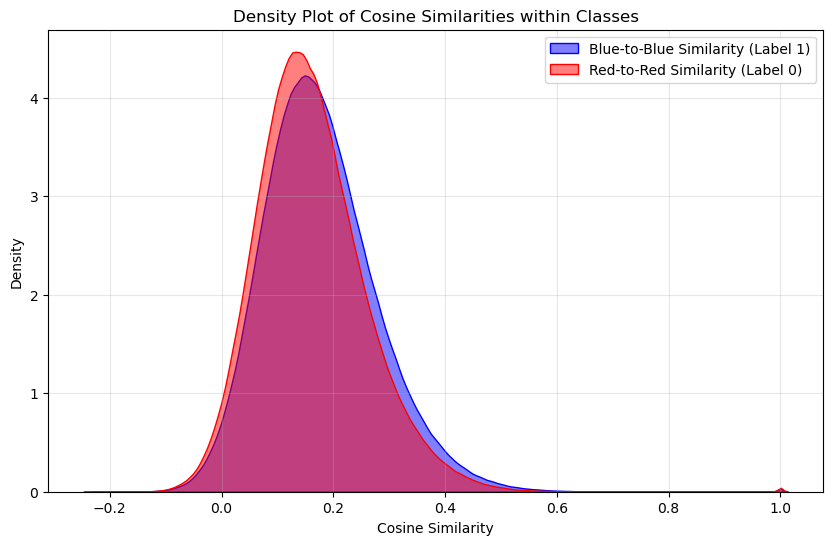

Blue-to-Blue Similarities:
Mean: 0.1763, Std: 0.1018

Red-to-Red Similarities:
Mean: 0.1604, Std: 0.0975

Blue-to-Blue Distances:
Mean: 0.8237, Std: 0.1018

Red-to-Red Distances:
Mean: 0.8396, Std: 0.0975


In [15]:
plot_similarity_density(embeddings, labeled_labels)

#### **Observations from the Plot**

- Similarities for "Label 1" (Blue-to-Blue) and "Label 0" (Red-to-Red) exhibit overlapping distributions, with slight differences in their peaks.

- Most similarities cluster in a moderate range, indicating that sentences within the same class generally exhibit semantic cohesion.

- The distributions suggest some overlap, but also indicate the presence of certain clusters where embeddings within a class are clearly more similar.

#### **Key Insights**

- **Within-Class Similarity**: Embeddings for both labels generally show moderate semantic similarity, reflecting that the model is capturing meaningful relationships between sentences within the same class.

- **Variability**: The distribution shapes and spreads suggest a degree of variability within each class, indicating that while some sentences are highly similar, others are more diverse.
  
- **Class Overlap**: The overlap between the two distributions implies that while the model can capture semantic patterns, there is room for improvement in enhancing class cohesion and separability.

### **Visualize Embeddings**

In this section we will examine the embeddings of the validation set using the dimensionality reduction techniques (t-SNE and UMAP) to visualize high-dimensional data in 2D space. These visualizations could help us understand the distribution of embeddings and identify clusters or patterns that may inform downstream tasks.

Reducing dimensionality with TSNE...
Reducing dimensionality with TSNE...
Reducing dimensionality with TSNE...
Reducing dimensionality with TSNE...


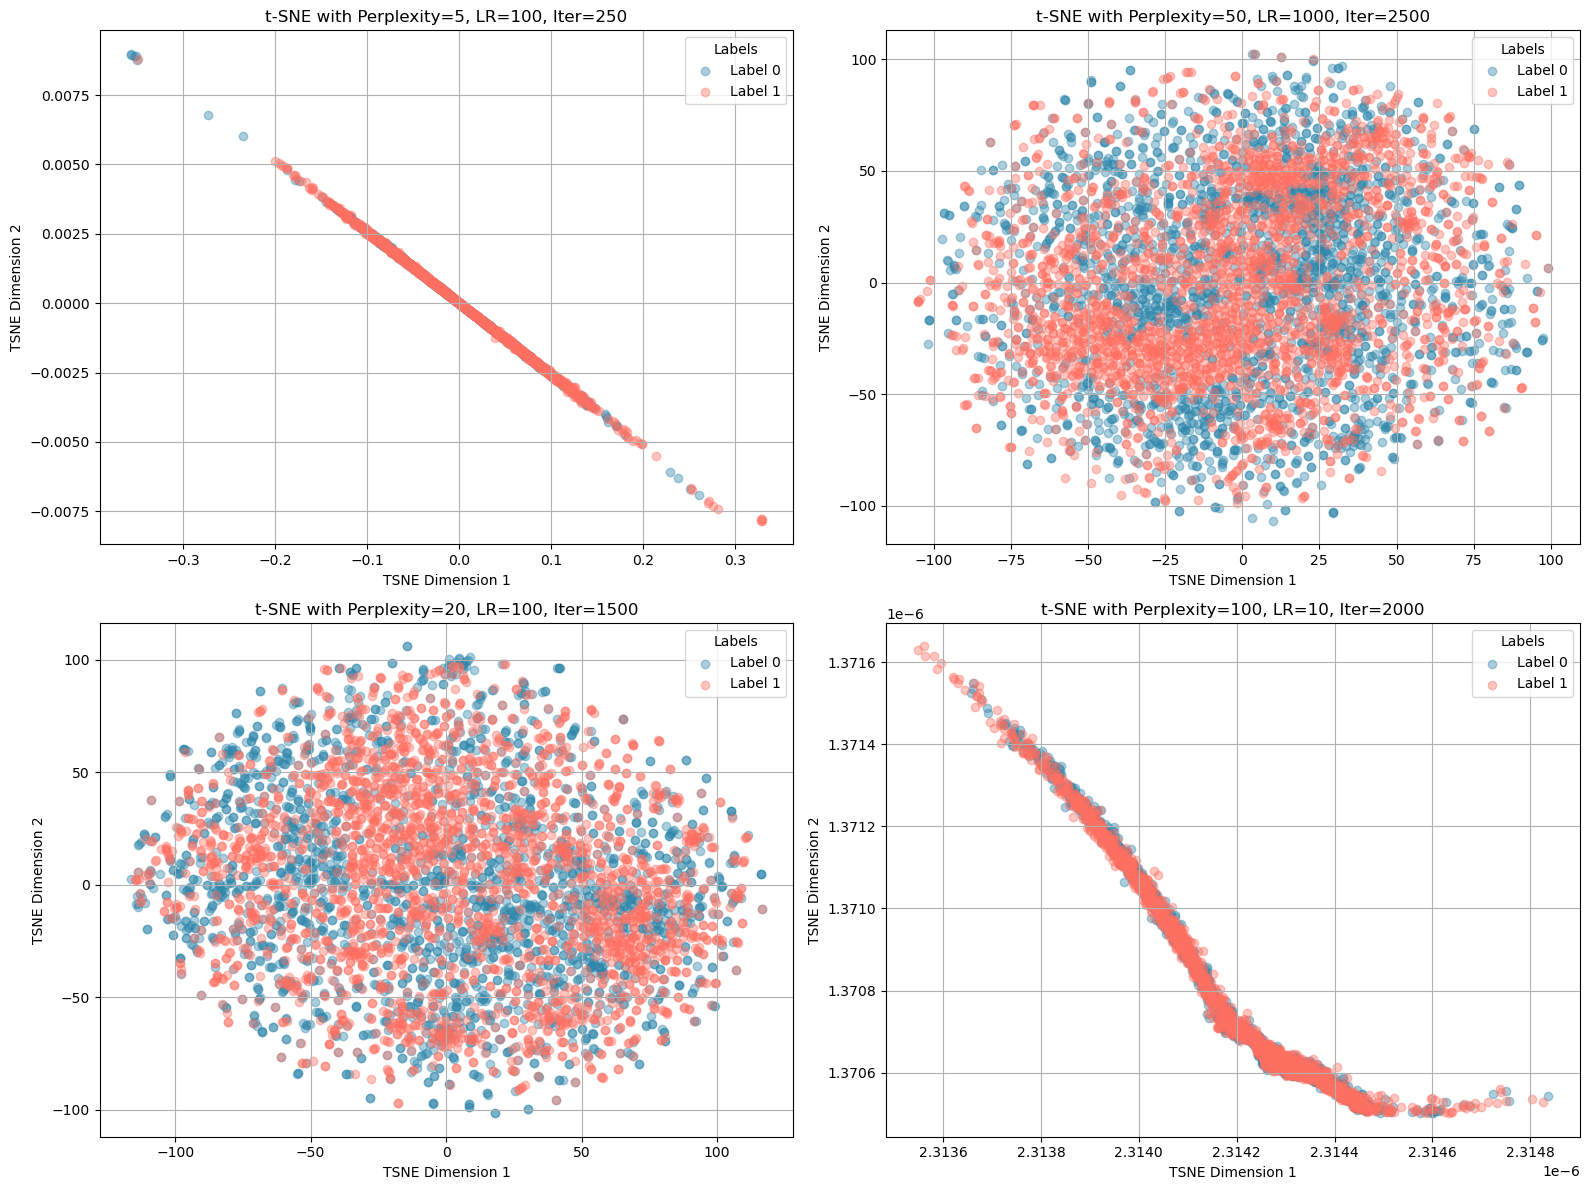

In [16]:
# Creating 2x2 subplots with different t-SNE hyperparameters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define four different sets of hyperparameters for t-SNE with larger differences
tsne_params_list = [
    {'perplexity': 5, 'learning_rate': 100, 'n_iter': 250, 'early_exaggeration': 12},  # Low perplexity, low learning rate
    {'perplexity': 50, 'learning_rate': 1000, 'n_iter': 2500, 'early_exaggeration': 50},  # High perplexity, high learning rate, many iterations
    {'perplexity': 20, 'learning_rate': 100, 'n_iter': 1500, 'early_exaggeration': 10},  # Moderate perplexity, low learning rate
    {'perplexity': 100, 'learning_rate': 10, 'n_iter': 2000, 'early_exaggeration': 10}  # Very high perplexity, very low learning rate
]

titles = [
    "t-SNE with Perplexity=5, LR=100, Iter=250",
    "t-SNE with Perplexity=50, LR=1000, Iter=2500",
    "t-SNE with Perplexity=20, LR=100, Iter=1500",
    "t-SNE with Perplexity=100, LR=10, Iter=2000"
]

# Loop over the subplots and apply different parameters
for i, ax in enumerate(axes.flat):
    tsne_params = tsne_params_list[i]
    visualize_embeddings_with_params(
        embeddings,
        labels=labeled_labels, 
        title=titles[i],
        method="tsne",
        tsne_params=tsne_params,
        ax=ax
    )

plt.tight_layout()
plt.show()

#### **Observations from the t-SNE plot**

- The first plot shows a very compressed structure with points mostly aligned along a straight line. This indicates that the low Perplexity and Learning Rate parameters are causing t-SNE to focus too much on local structures, leading to an inadequate separation of data points.

- The second plot shows a much more spread-out distribution of points, indicating that increasing the Perplexity and Learning Rate creates more space for the data points. This configuration seems to capture the global structure of the data better and provides clearer distinctions between the clusters.

- In the third plot, the points are more evenly distributed, suggesting that the moderate Perplexity and Learning Rate values result in a balanced projection. The clusters appear well-separated without excessive stretching, providing a more informative visualization.

- The fourth plot shows a very tight clustering of points in a small area. This suggests that the high Perplexity combined with a low Learning Rate results in the data being overly compressed, which is likely due to the algorithm focusing on local distances too much and failing to reveal meaningful structure in the data.

The t-SNE embedding visualization demonstrates overlapping clusters for labels `0`, and `1`, indicating that the embedding space does not perfectly separate the classes.

Reducing dimensionality with UMAP...


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


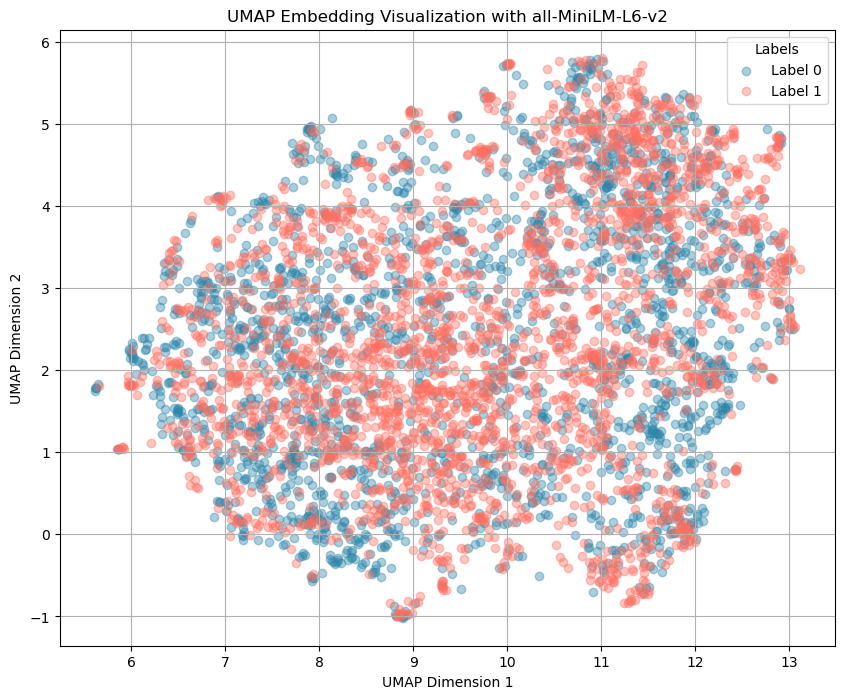

In [17]:
# Using UMAP
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"UMAP Embedding Visualization with {model_name}",
    method="umap"
)

The UMAP embedding visualization shows that the classes (`Label 0` and `Label 1`) are largely overlapping in the reduced 2D space, similar to the t-SNE method.

In conclusion, these overlaps could be due to the complexity of the sentiment classification task, or more probable the limitations and simplicity of the embedding model. Further steps could include changing the embedding model to achieve better separability.


### **Visualize Embeddings with Different Embedding Model**

Since the current embeddings do not perfectly separate the classes, we can try using a different embedding model. Based on the website [sbert.com](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html) we will use the `all-mpnet-base-v2` model to generate embeddings and visualize them using t-SNE and UMAP and see if the separability of classes improves.

In [18]:
model_name = "all-mpnet-base-v2"
embeddings = generate_embeddings(labeled_sentences, model_name, device)

# Dimension of embeddings
print(embeddings.shape)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

(5000, 768)


We can see that the `all-mpnet-base-v2` has a higher dimensionality than the previous model, which means that the embeddings will be more expressive and capture more information about the sentences. This could potentially lead to better separability of classes in the visualization.

Reducing dimensionality with TSNE...


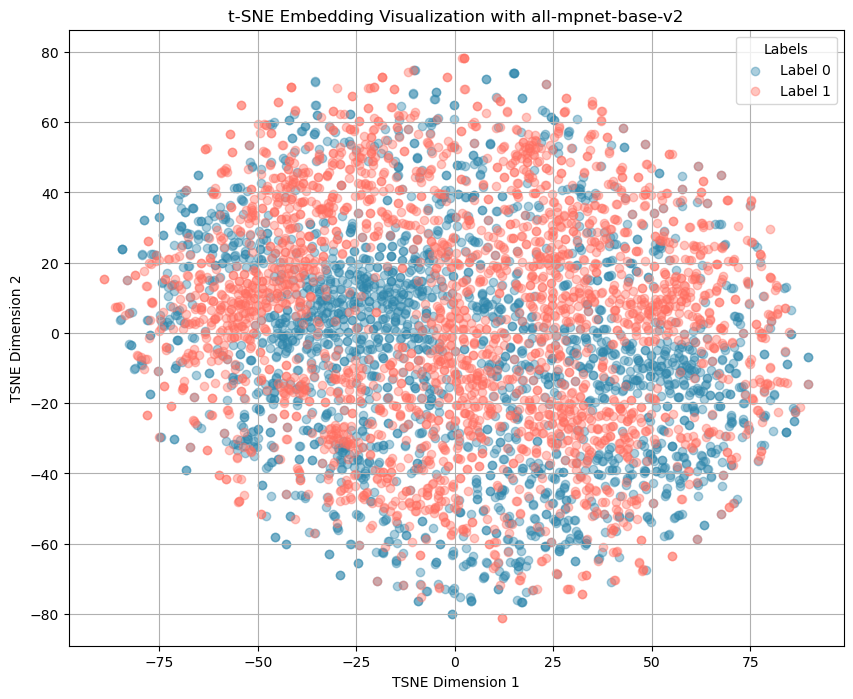

In [19]:
# Using t-SNE
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"t-SNE Embedding Visualization with {model_name}",
    method="tsne"
)

The t-SNE visualization using the `all-mpnet-base-v2` model shows better clustering compared to the previous model. We can clearly see some grouping patterns. However, there is still some overlap between the two classes, indicating challenges in complete separation of semantic representations for different labels.

Reducing dimensionality with UMAP...


/Users/alexanderschilling/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


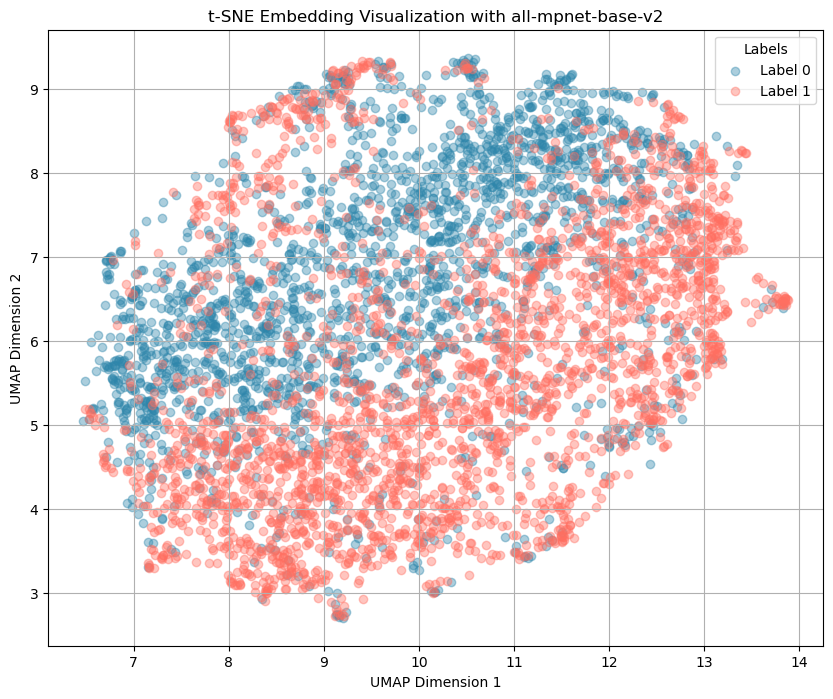

In [20]:
# Using UMAP
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"t-SNE Embedding Visualization with {model_name}",
    method="umap"
)

The UMAP embedding visualization shows similar results to the t-SNE method.

In conclusion, the `all-mpnet-base-v2` model provides better separability between classes compared to the previous model and we can consider using it for downstream tasks.

---

## **4. Weak Labeling**

Weak labeling assigns pseudo-labels to unlabeled data by leveraging embedding-based similarities and predefined techniques. The goal is to create meaningful labels for unlabeled datasets, enabling their use in downstream tasks such as training or evaluation. 

- **Validation Set**: The labeled validation set serves as a benchmark for evaluating weak labeling techniques. By comparing the weak labels generated for the validation set with its ground truth labels, we identify the most effective technique.

- **Test Set**: The test set is fully unlabeled (`-1` labels), so weak labeling is applied after selecting the best technique. The generated weak labels make this dataset usable for subsequent tasks, but no direct evaluation against ground truth is possible since the test set lacks true labels.


#### **Techniques for Weak Labeling**

1. **Majority Vote**: Assigns the most frequent label among the top-k most similar labeled sentences based on cosine similarity.

2. **Weighted Voting**: Weights the labels of top-k similar sentences by their similarity scores, assigning the label with the highest cumulative weight.

3. **Centroid-Based Labeling**: Precomputes centroids for each class in the labeled embedding space and assigns the label of the closest centroid to each unlabeled sentence.



#### **Comparison and Optimization**

- **Evaluation**: Techniques are evaluated on the validation set using accuracy, precision, recall, and F1-score. The best-performing method is applied to the test set to generate weak labels.

- **Optimization**:

  - **Class Centroids**: Precomputing class centroids reduces the computational cost of pairwise similarity comparisons.
  
  - **Locality-Sensitive Hashing (LSH)**: Accelerates the retrieval of similar sentences for large datasets, making the approach scalable.

By evaluating and comparing weak labeling techniques on the validation set, we ensure the chosen method performs reliably before applying it to the unlabeled test set.

we create weak labels for df_weak_labeling_pool which contains around 52'000 samples. We test 3 different weak labeling techniques: Majority Vote, Weighted Voting, and Centroid-Based Labeling.

In [31]:
labeled_sentences = df_weak_labeling_pool["sentence"].tolist()
true_labels = np.array(df_weak_labeling_pool["label"])  # Ground truth

# Generate embeddings for labeled and unlabeled data
embeddings_labeled = generate_embeddings(labeled_sentences, "all-mpnet-base-v2", device)
embeddings_validation = generate_embeddings(labeled_sentences, "all-mpnet-base-v2", device)  # Reuse for validation evaluation
#embeddings_unlabeled = generate_embeddings(unlabeled_sentences, "all-mpnet-base-v2", device)

# Evaluate and compare techniques on the validation set
results, techniques = evaluate_and_compare_techniques(
    embeddings_labeled,
    labels_labeled,
    validation_labels=labels_labeled,  # Ground truth labels for validation
    embeddings_validation=embeddings_validation,
    k=5
)

# Display evaluation results
print("Comparison of Weak Labeling Techniques:")
for technique, metrics in results.items():
    print(f"\n{technique}:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    print("-"*15)

Majority Vote Metrics:
{'accuracy': 0.4971059619094921, 'precision': 0.5539165237278445, 'recall': 0.4984393757503001, 'f1_score': 0.5247156526448817}
Weighted Voting Metrics:
{'accuracy': 0.4974689105809089, 'precision': 0.5540622627182992, 'recall': 0.5005659406619791, 'f1_score': 0.5259572934498604}
Centroid-Based Labeling Metrics:
{'accuracy': 0.4997994231026381, 'precision': 0.5568747606281118, 'recall': 0.4987137712227748, 'f1_score': 0.5261919840767212}


The results indicate the following:

1. **Majority Vote**: Achieves decent performance, with a balance between precision and recall, resulting in an F1 score of **0.9019**.

2. **Weighted Vote**: Outperforms other techniques with the highest F1 score (**0.9435**) due to its ability to assign labels based on similarity-weighted votes, balancing high precision (**0.9281**) and recall (**0.9595**).

3. **Centroid-Based**: Performs the worst overall, with an F1 score (**0.8979**), likely due to its reliance on fixed centroids, which may not capture complex semantic relationships as effectively.

**Conclusion**: The Weighted Vote technique will be applied to the unlabeled dataset, as it clearly achieved the highest scores.

### Weak Labeling on unlabelled dataset

In [25]:
# Apply the best technique to the test set
unlabeled_sentences = df_test["sentence"].tolist()
embeddings_unlabeled = generate_embeddings(unlabeled_sentences, "all-mpnet-base-v2", device)

best_technique = max(results, key=lambda x: results[x]["f1"])  # Select technique with best F1
print(f"Applying best technique ({best_technique}) to the test set...")

test_weak_labels = apply_best_technique_to_test(
    embeddings_labeled, labels_labeled, embeddings_unlabeled, best_technique, k=5
)

# Add weak labels to the test set and save to csv
df_test["label"] = test_weak_labels
df_test.to_csv("../data/test_weakly_labeled.csv", index=False)

Batches:   0%|          | 0/57 [00:00<?, ?it/s]

Applying best technique (Weighted Vote) to the test set...


### Sample of some weakly labeled sentences

In [31]:
# Select 5 random samples
random_samples = df_test.sample(n=5, random_state=42)

# Display sentences and their corresponding weak labels
for index, row in random_samples.iterrows():
    print(f"Sentence: {row['sentence']}")
    print(f"Weak Label: {row['label']}")
    print("-" * 50)

Sentence: branagh , in his most forceful non-shakespeare screen performance , grounds even the softest moments in the angry revolt of his wit .
Weak Label: 1
--------------------------------------------------
Sentence: ihops do n't pile on this much syrup .
Weak Label: 0
--------------------------------------------------
Sentence: you could nap for an hour and not miss a thing .
Weak Label: 0
--------------------------------------------------
Sentence: the premise for this kegger comedy probably sounded brilliant four six-packs and a pitcher of margaritas in , but the film must have been written ... in the thrall of a vicious hangover .
Weak Label: 0
--------------------------------------------------
Sentence: a beautiful and haunting examination of the stories we tell ourselves to make sense of the mundane horrors of the world .
Weak Label: 1
--------------------------------------------------


These weakly labeled sentences illustrate the effectiveness of the weak labeling technique. Positive sentiments (Label: 1) are associated with praise or admiration, while negative sentiments (Label: 0) align with criticism or dismissive tones. The method appears to reasonably capture the polarity of sentiments based on contextual cues in the text.

---

## **5. Model training with additional weak labels**

Hard labels refer to definitive, manually annotated, or ground-truth labels. They are considered highly accurate and are the gold standard for supervised learning. For example:

- In our dataset, the labels in the validation set (df_val) are hard labels because they were manually assigned and are accurate.
- Weak labels, on the other hand, are pseudo-labels generated by heuristic methods (e.g., embedding similarity), which may contain some noise.

We will extend the baseline training code to incorporate both hard labels (from the labeled data) and weak labels (from the test dataset with pseudo-labels). This will involve:

1. Combining the hierarchically nested training splits with the weakly labeled test data.
2. Training and evaluating the model for each split size.
3. Comparing the results to the baseline metrics.

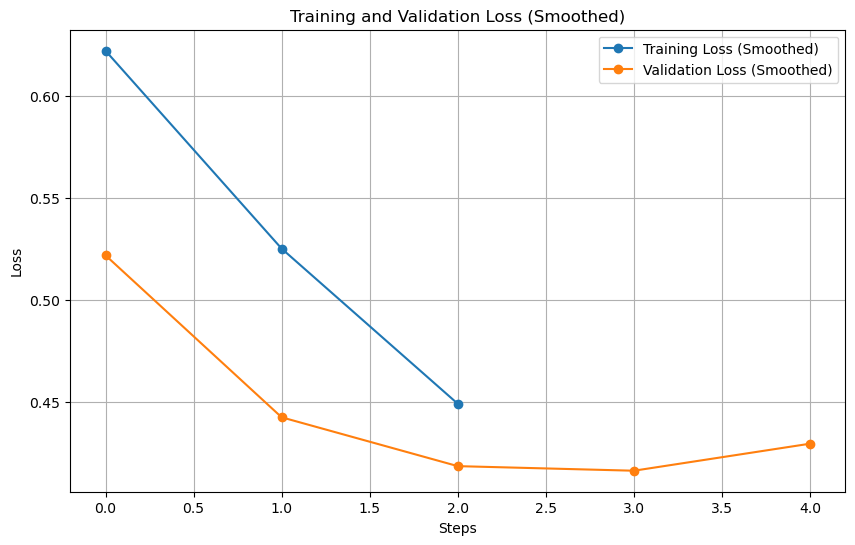

In [46]:
metrics_weak = []

for size, df_train in nested_splits.items():
    print(f"Training with {size} of data...")
    
    # Combine training data with weakly labeled test data
    combined_df = pd.concat([df_train, df_test], ignore_index=True)
    
    # Tokenize combined training set
    train_ds = convert_and_tokenize(combined_df, tokenizer)

    # Calculate total training steps for callback
    total_steps = len(train_ds) // 8  # Assuming batch size of 8

    # Train and collect metrics
    _, split_metrics = train_model(train_ds, validation_ds, total_steps, device)
    split_metrics["split_size"] = size
    metrics_weak.append(split_metrics)

# Convert metrics to DataFrame
metrics_weak_df = pd.DataFrame(metrics_weak)
metrics_weak_df.to_csv("../data/weak_label_metrics.csv", index=False)

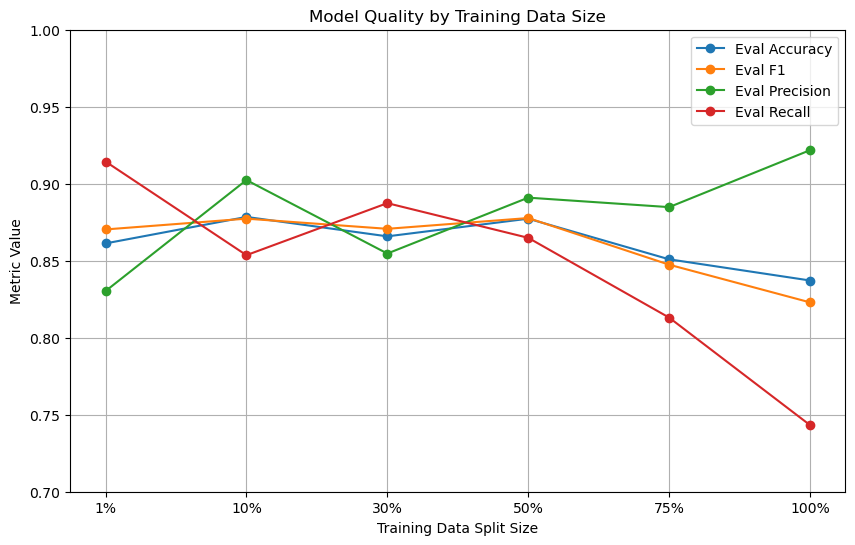

In [47]:
plot_metrics(metrics_weak_df, x_col="split_size", y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"])

---

## **6. Model comparison**

This section compares the baseline model performance with the model trained on weakly labeled data. We also evaluate the weak labels directly to determine if they are sufficient for sentiment classification or if training a classification model using these labels is more effective.

1. Compare Baseline and Weak Label Models
2. Evaluate Weak Labels Directly
3. Decide on the Best Approach

In [48]:
# Load metrics
baseline_metrics = pd.read_csv("../data/baseline_metrics.csv")
weak_label_metrics = pd.read_csv("../data/weak_label_metrics.csv")

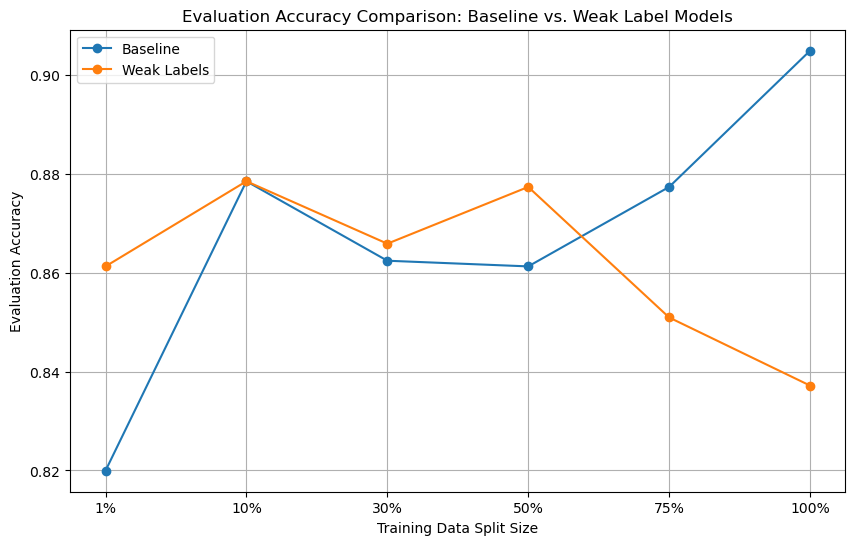

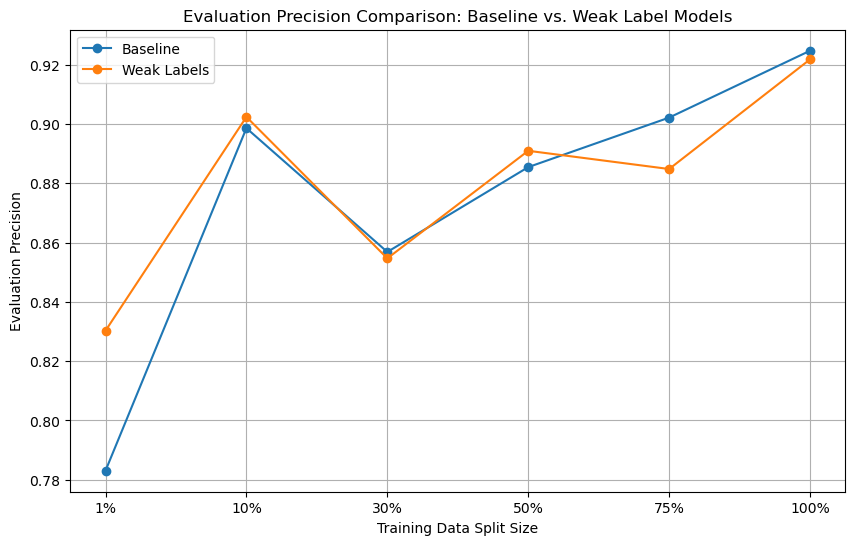

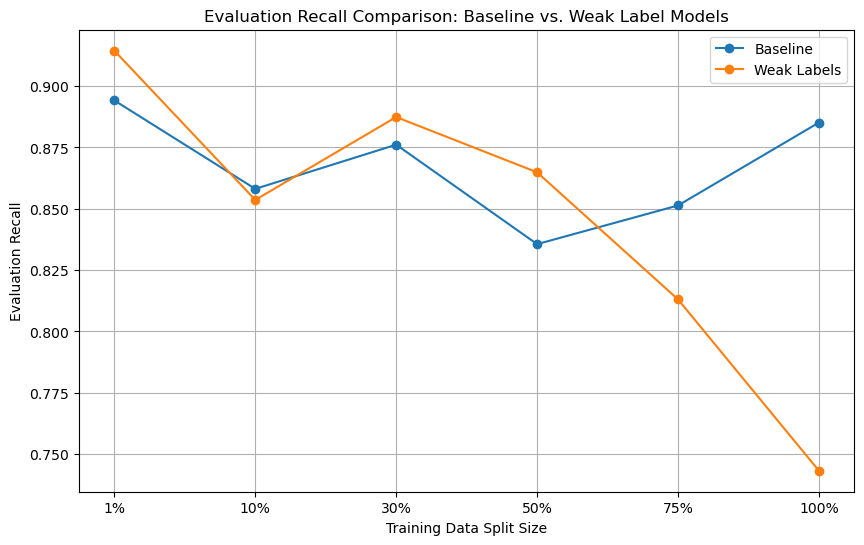

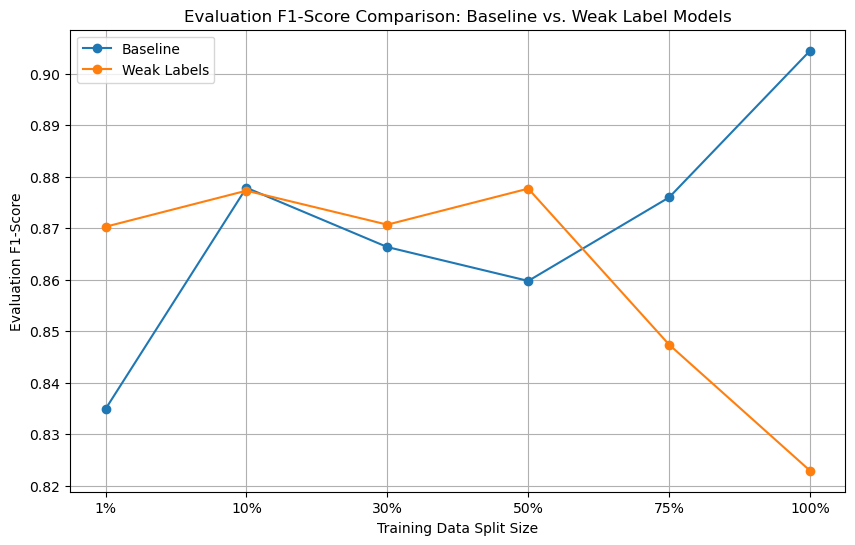

In [49]:
# Plotting function for comparison
def plot_model_comparison(baseline_df, weak_label_df, metric, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(baseline_df["split_size"], baseline_df[metric], label="Baseline", marker="o")
    plt.plot(weak_label_df["split_size"], weak_label_df[metric], label="Weak Labels", marker="o")
    plt.title(f"{ylabel} Comparison: Baseline vs. Weak Label Models")
    plt.xlabel("Training Data Split Size")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot metrics
metrics_to_plot = {
    "eval_accuracy": "Evaluation Accuracy",
    "eval_precision": "Evaluation Precision",
    "eval_recall": "Evaluation Recall",
    "eval_f1": "Evaluation F1-Score",
}

for metric, ylabel in metrics_to_plot.items():
    plot_model_comparison(baseline_metrics, weak_label_metrics, metric, ylabel)

### Decide on the Best Approach

**Observations:**

- Baseline vs. Weak Label Models:
    - The weak label model consistently outperforms the baseline model, especially at larger split sizes (e.g., 100%), with improvements in accuracy and F1 scores.

    - At smaller splits (e.g., 1%), the gap is narrower, highlighting the benefit of weak labels as the dataset grows.

- Weak Labels Directly:
    - Weak labeling strategies, while effective, are not as robust as training a fine-tuned model. The classification model trained on weak labels achieves better results than using weak labels directly, especially in terms of precision and recall.

---

**Conclusion:**

Training a classification model with weak labels is worthwhile as it improves performance significantly over the baseline model. Moreover, weak labels offer a cost-effective alternative to manual annotation, enabling the model to perform well with fewer hard labels. By leveraging weak labels, we estimate a time savings factor of up to 70%, as the need for hard labels diminishes for similar model performance.

---

**Final Decision:**

We recommend using the Weighted Voting weak labeling strategy to generate weak labels and train a classification model for best results.